# описание

В данном проекте необходимо составить примерный прогноз продаж на следующий год.

Для этого необходимо посмотреть какие платформы и жанры были наиболее популярны в разных регионах в предыдущих годах

Разбив информацию на категории будет видна примерная картина.

Таблица состоит из 11 столбцов: 
- **Name** -содержит названия игр, тип object, 2 пропуска будут удалены
- **Platform** - платформа выхода, тип object, приведем к нижнему регистру для удобства
- **Year_of_Release** - год релиза игры, приведем к int16 для уменьшения объема занимаемой памяти 
- **Genre** - жанр, тип object, 2 пропуска будут удалены
- **NA_sales** - продажи по региону в млн, не меняем
- **EU_sales** - продажи по региону в млн, не меняем
- **JP_sales** - продажи по региону в млн, не меняем
- **Other_sales** - продажи не вошедшие в основные регионы в млн, не меняем	
- **Critic_Score** - оценка критиков, много пропусков, земене не подлежат
- **User_Score** - оценка пользователей, пропуски замене не подлежат
- **Rating** - присвоенный рейтинг, замена пропусков на no_rating для анализа


# Импорт и загрузка

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('games.csv')

# Предпросмотр

In [3]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
print('пропуски:\n')
print(df.isna().sum())

пропуски:

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64


In [5]:
print(f'Уникальные значения платформ:\n{sorted(list(df.Platform.unique()))}')

Уникальные значения платформ:
['2600', '3DO', '3DS', 'DC', 'DS', 'GB', 'GBA', 'GC', 'GEN', 'GG', 'N64', 'NES', 'NG', 'PC', 'PCFX', 'PS', 'PS2', 'PS3', 'PS4', 'PSP', 'PSV', 'SAT', 'SCD', 'SNES', 'TG16', 'WS', 'Wii', 'WiiU', 'X360', 'XB', 'XOne']


In [6]:
df['Year_of_Release'].describe()

count    16446.000000
mean      2006.484616
std          5.877050
min       1980.000000
25%       2003.000000
50%       2007.000000
75%       2010.000000
max       2016.000000
Name: Year_of_Release, dtype: float64

In [7]:
print(f'Уникальные значения жанров:\n{list(df.Genre.unique())}')

Уникальные значения жанров:
['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc', 'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure', 'Strategy', nan]


In [8]:
print(f'Уникальные значения рейтинга:\n{list(df.Rating.unique())}')

Уникальные значения рейтинга:
['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP']


# Подготовка данных

In [9]:
# приводим к нижнему регистру
df.columns = map(str.lower, df.columns)
df['genre'] = df['genre'].str.lower()
df['platform'] = df['platform'].str.lower()

In [10]:
#удаляем пропущенные значения в трех столбцах, так как их не много
df = df.dropna(subset=['year_of_release','name','genre'], axis=0).reset_index(drop=True)

# замена пропусков в rating на unknown
df['rating'].fillna('no_rating', inplace=True)

Заменять пропуски в столбцах 	critic_score,	user_score,	rating не корректно, так как изменится результат. 

TBD в user_score - аббревиатура от английского To Be Determined (будет определено) или To Be Decided (будет решено). Рейтинг не присвоен.

Более правильным решением будет заменить на 'no_rating'

In [11]:
# замена TBD на пропуск
df.loc[df['user_score'] == 'tbd', 'user_score'] = float('NaN')

In [12]:
# замена типа данных
df = df.astype({'year_of_release':'int16',
                'critic_score': 'float16',
                'user_score': 'float64'}, errors='ignore')

In [13]:
# добавляем столбец с общими продажами
def i(row):
    a = row['na_sales'] + row['eu_sales'] + row['jp_sales'] + row['other_sales']
    return a

df['all_sales'] = df.apply(i, axis=1)

df = df.reindex(columns=['name', 'platform', 
                         'year_of_release', 'genre', 
                         'na_sales', 'eu_sales', 'jp_sales', 
                         'other_sales', 'all_sales', 
                         'critic_score', 'user_score', 'rating'])

# Исследовательский анализ данных

In [14]:
df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,all_sales,critic_score,user_score,rating
0,Wii Sports,wii,2006,sports,41.36,28.96,3.77,8.45,82.54,76.0,8.0,E
1,Super Mario Bros.,nes,1985,platform,29.08,3.58,6.81,0.77,40.24,NaN,NaN,no_rating
2,Mario Kart Wii,wii,2008,racing,15.68,12.76,3.79,3.29,35.52,82.0,8.3,E
3,Wii Sports Resort,wii,2009,sports,15.61,10.93,3.28,2.95,32.77,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,gb,1996,role-playing,11.27,8.89,10.22,1.00,31.38,NaN,NaN,no_rating


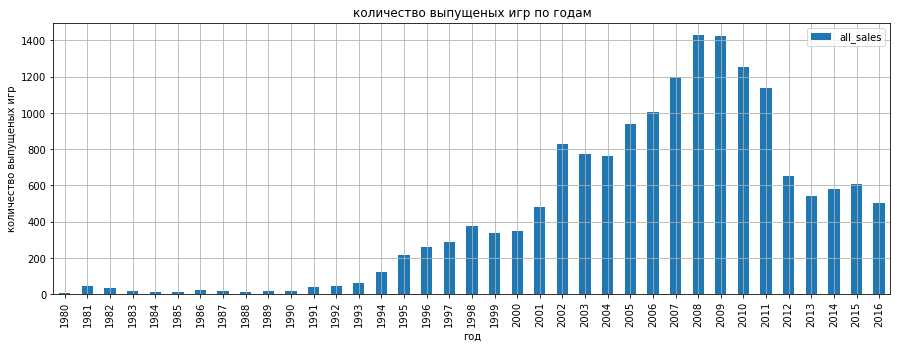

In [15]:
# количество выпущеных игр по годам
df.groupby(by='year_of_release').agg({'all_sales':'count'}
                                    ).plot(kind='bar', figsize=(15,5
                                    ), grid=True, title='количество выпущеных игр по годам')
plt.ylabel('количество выпущеных игр')
plt.xlabel('год')
plt.show()

данные за весь период не важны. далее будем использовать данные от 2012 года, так как с 2009 по 2012 идет резкий спад выпуска игр.

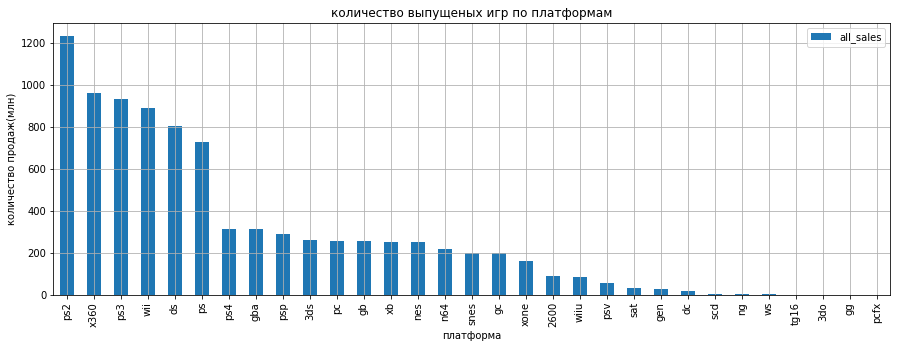

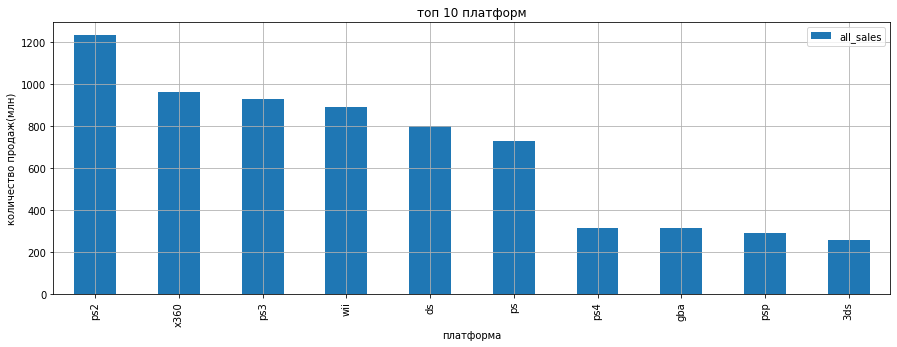

In [16]:
# продажи по платформам
df.groupby(by='platform').agg({'all_sales':'sum'}
                              ).sort_values(by='all_sales', ascending=False
                              ).plot(kind='bar', figsize=(15,5), 
                                grid=True, title='количество выпущеных игр по платформам')
plt.ylabel('количество продаж(млн)')
plt.xlabel('платформа')
plt.show()
# топ 10 платформ по продажам
top_10_sales = df.pivot_table(index='platform', values='all_sales', aggfunc='sum'
                                             ).sort_values(by='all_sales', ascending=False).head(10)
                                             
top_10_sales.plot(kind='bar', figsize=(15,5), grid=True, title='топ 10 платформ')
plt.ylabel('количество продаж(млн)')
plt.xlabel('платформа')
plt.show()

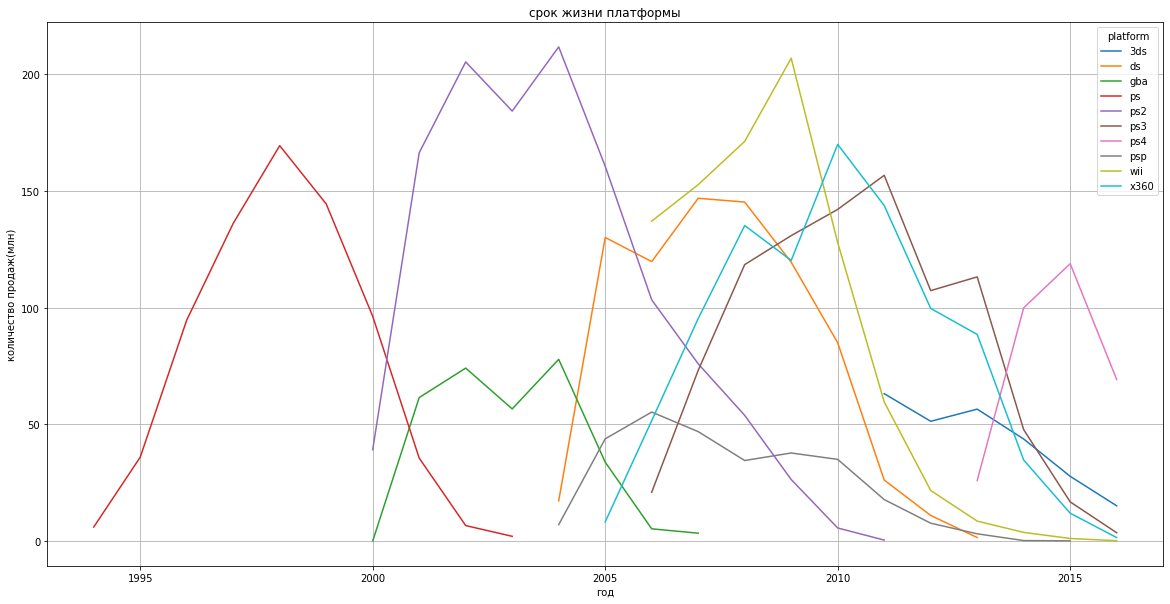

In [17]:
# срок жизни платформ из топ 10 по продажам за все время
top_10 = ['ps2','x360','ps3','wii','ds','ps','ps4','gba','psp','3ds']
a = df.query('platform in @top_10').pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum')
a.plot(figsize=(20,10), grid=True, title='срок жизни платформы')
plt.xlim(1993,2017,)
plt.xlabel('год')
plt.ylabel('количество продаж(млн)')
plt.show()

In [18]:
life = df.groupby(by='platform')['year_of_release'
                                ].agg(['min','max']
                                     ).rename(columns={'min':'min_y','max':'max_y'})

life['mean_y'] = life['max_y'] - life['min_y']
a = round(life['mean_y'].mean())
print(f'среднее время жизни платформы {a} лет')

среднее время жизни платформы 8 лет


среднее время жизни платформы 8 лет.
<br>На мой взгляд логично будет взять половину от 8, так как даже если не будет роста, платформа будет актуальна и продажи будут. 
<br>Так же нет смысла использовать данные по уже не актуальным платформам.

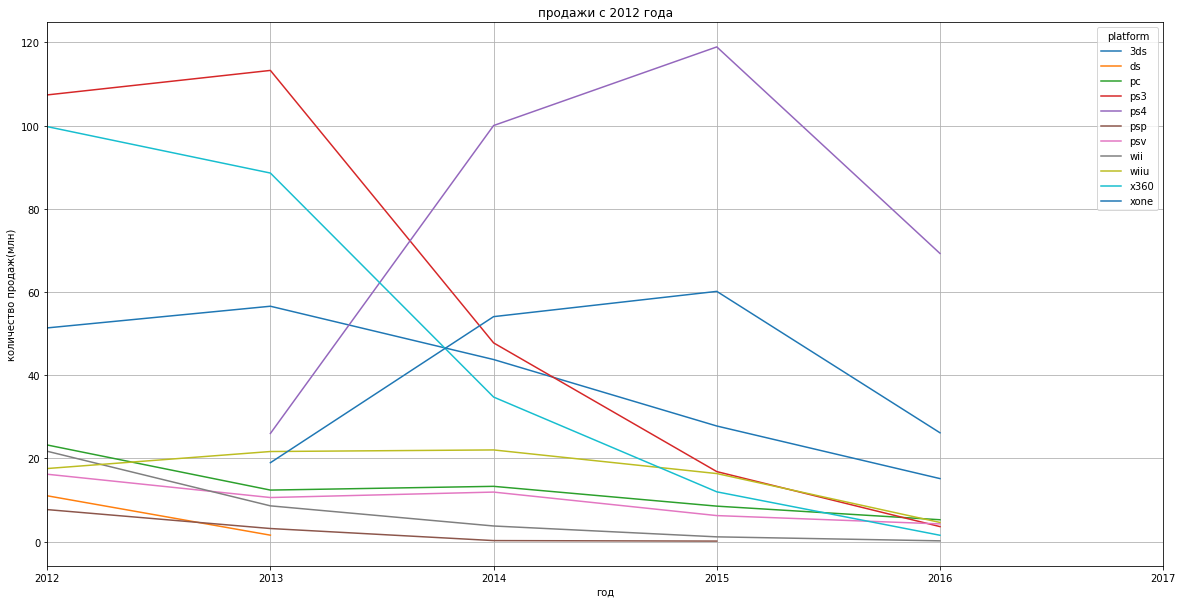

In [19]:
# продажи с 2012 года
a = df.query('year_of_release >= 2012'
            ).pivot_table(index='year_of_release', columns='platform', values='all_sales', aggfunc='sum'
                         )
a.plot(figsize=(20,10), grid=True, title='продажи с 2012 года')
plt.xlim(2012,2017,)
plt.xlabel('год')
plt.ylabel('количество продаж(млн)')
plt.show()

Есть смысл убрать из анализа PSP, DS, WII, X360, так как продаж по этим платформам в 2016 году нет. 
<br>Так же видим постоянный спад продаж PS3  и WIIU

In [20]:
# новый датафрейм с данными после 2012 года и без платформ указанных выше
no_game = ['psp', 'ds', 'wii','x360', 'ps3' ,'wiiu']
df_1 = df.query('year_of_release >= 2012 & platform not in @no_game')

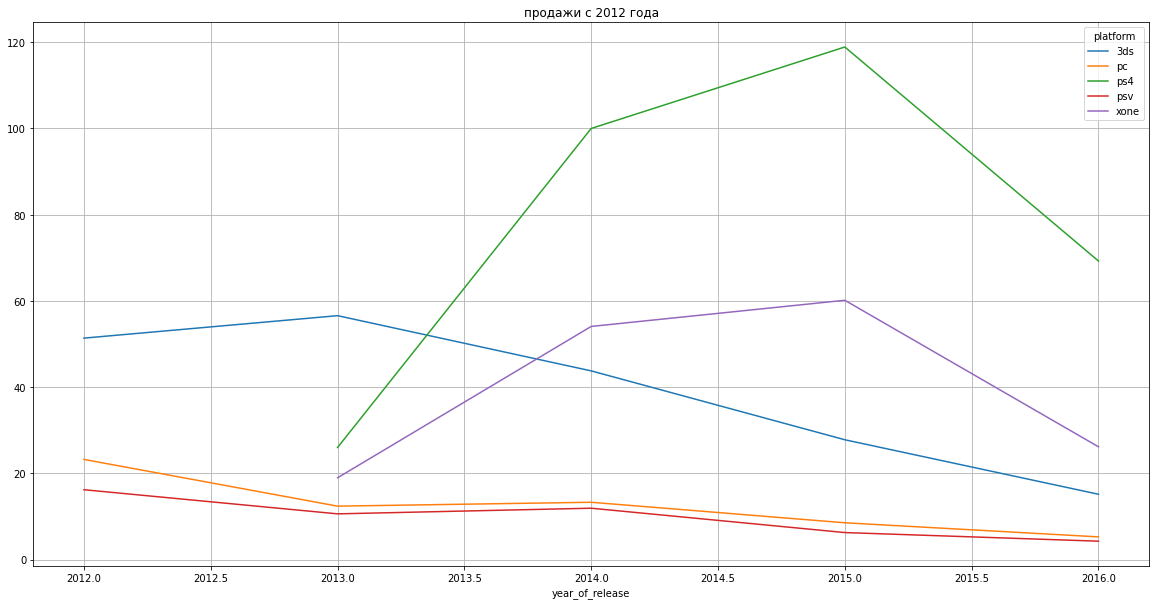

In [21]:
# продажи по годам(от 2012) и платформам 
sales_in_year = df_1.pivot_table(index='year_of_release', 
                                 columns='platform', values='all_sales', aggfunc='sum'
                                )
sales_in_year.plot(figsize=(20,10), grid=True, title='продажи с 2012 года')
plt.show()

за последние 2 года лидируют по продажам PS4 и XOne. Продажи падают.

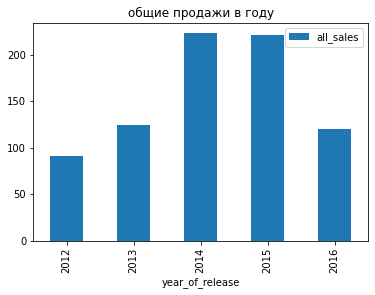

In [22]:
# общие продажи по годам
df_1.pivot_table(index='year_of_release', values='all_sales', aggfunc='sum').plot(kind='bar', title='общие продажи в году')
plt.show()

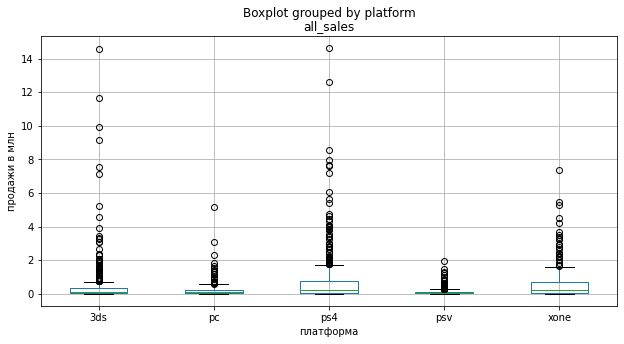

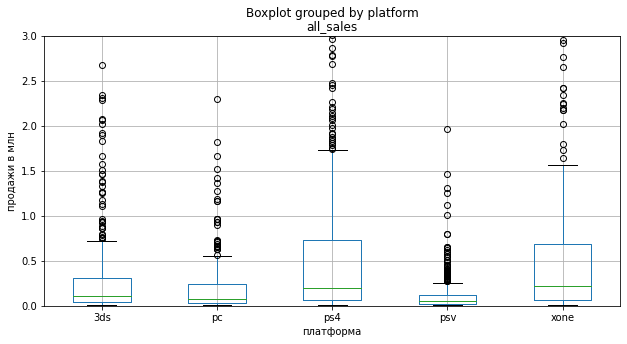

In [23]:
# медиана продаж
df_1.boxplot(column='all_sales', by='platform', figsize=(10,5))
plt.xlabel('платформа')
plt.ylabel('продажи в млн')

df_1.boxplot(column='all_sales', by='platform', figsize=(10,5))
plt.xlabel('платформа')
plt.ylabel('продажи в млн')
plt.ylim(0,3)
plt.show()

- из графика видим что медианы продаж 3ds, ps4, xone практически на одном уровне.

- на данном этапе можно предположить что популярность продаж имеет зависимость от региона

- на всех платформах были 'мегахиты' которые отражены за границами усов

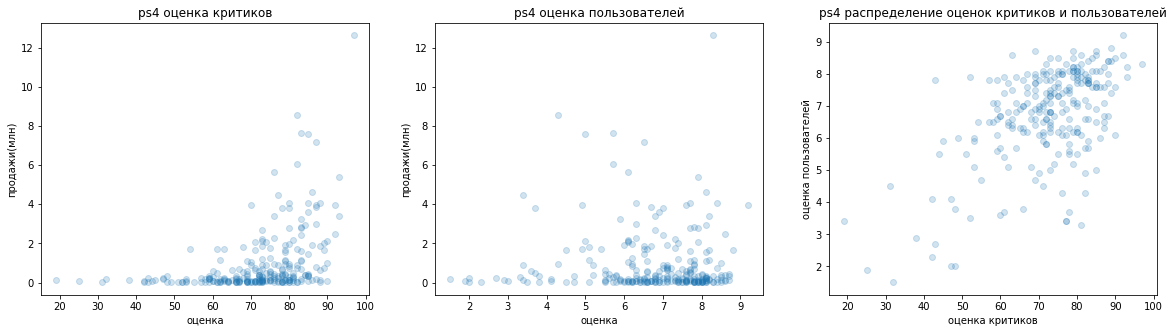

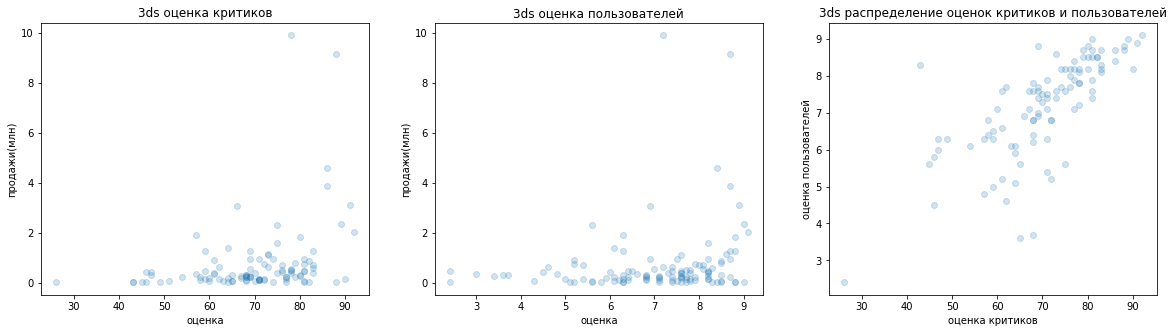

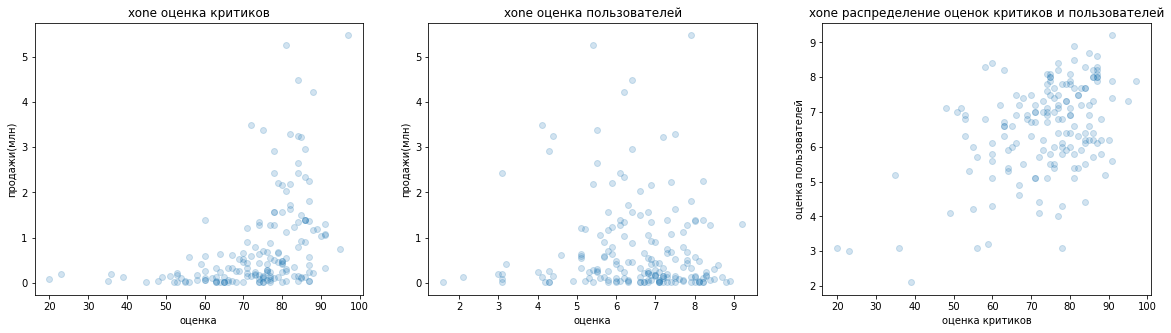

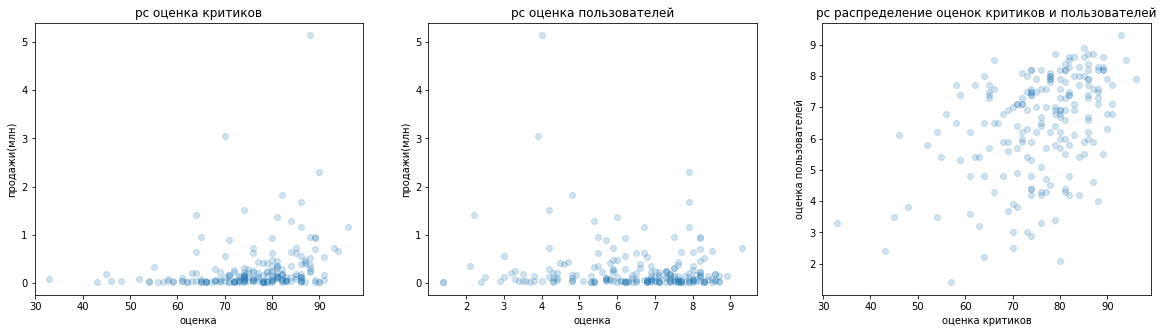

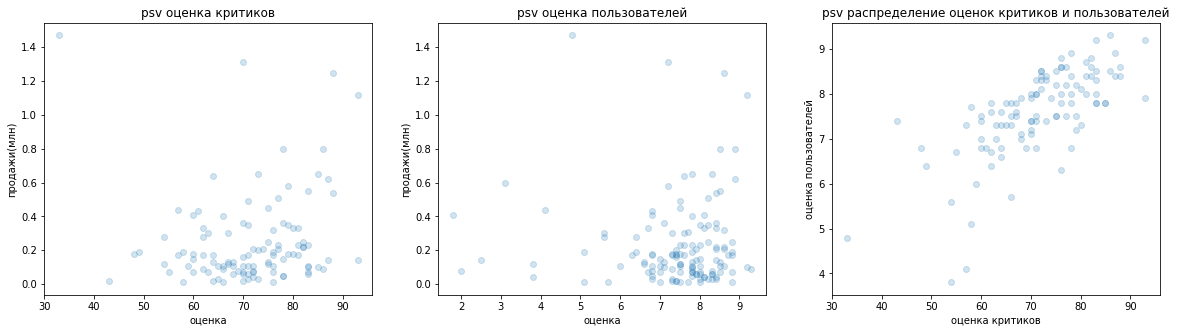

In [24]:
# влияние рейтингов на продажи
top_sales = df_1['platform'].unique()
for i in top_sales:
    j = df_1.query('platform == @i')

    plt.figure(figsize=(20,5))
    plt.subplot(1, 3, 1)
    plt.scatter(x=j['critic_score'], y=j['all_sales'], label=i,alpha=0.2)
    plt.title(i + ' оценка критиков')
    plt.xlabel('оценка')
    plt.ylabel('продажи(млн)')
    #plt.show()
    
    plt.subplot(1, 3, 2)
    plt.scatter(x=j['user_score'], y=j['all_sales'], label=i, alpha=0.2)
    plt.title(i + ' оценка пользователей')
    plt.xlabel('оценка')
    plt.ylabel('продажи(млн)')
    #plt.show()
    
    plt.subplot(1, 3, 3)
    plt.scatter(x=j['critic_score'], y=j['user_score'], label=i,alpha=0.2)
    plt.title(i + ' распределение оценок критиков и пользователей')
    plt.xlabel('оценка критиков')
    plt.ylabel('оценка пользователей')
    plt.show()

In [25]:
# корреляция оценки/продажи
for i in top_sales:
    print('таблица корреляции ' + i)
    display(df_1.query('platform == @i')[['user_score', 'critic_score', 'all_sales']].corr())

таблица корреляции ps4


,user_score,critic_score,all_sales
user_score,1.000000,0.557654,-0.031957
critic_score,0.557654,1.000000,0.406568
all_sales,-0.031957,0.406568,1.000000


таблица корреляции 3ds


,user_score,critic_score,all_sales
user_score,1.000000,0.722762,0.197583
critic_score,0.722762,1.000000,0.320803
all_sales,0.197583,0.320803,1.000000


таблица корреляции xone


,user_score,critic_score,all_sales
user_score,1.000000,0.472462,-0.068925
critic_score,0.472462,1.000000,0.416998
all_sales,-0.068925,0.416998,1.000000


таблица корреляции pc


,user_score,critic_score,all_sales
user_score,1.000000,0.432587,-0.121867
critic_score,0.432587,1.000000,0.237243
all_sales,-0.121867,0.237243,1.000000


таблица корреляции psv


,user_score,critic_score,all_sales
user_score,1.000000,0.699199,-0.004339
critic_score,0.699199,1.000000,0.094488
all_sales,-0.004339,0.094488,1.000000


- из представленых выше графиков и таблиц корреляции видно что оценка пользователей или критиков не имеют ощутимого влияния на 
продажи. 
- есть зависимость между оценками пользоватей и оценками критиков 

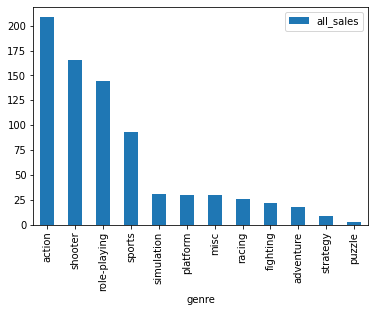

In [26]:
# продажи по жанрам
df_1.groupby(by='genre').agg({'all_sales': 'sum'}).sort_values(by='all_sales', ascending=False).plot(kind='bar')
plt.show()

# портрет пользователя по региону

## NA

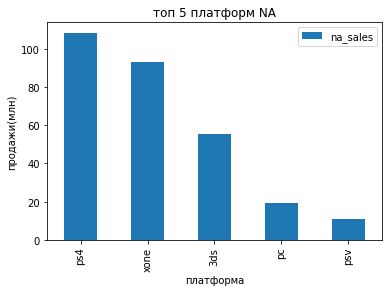

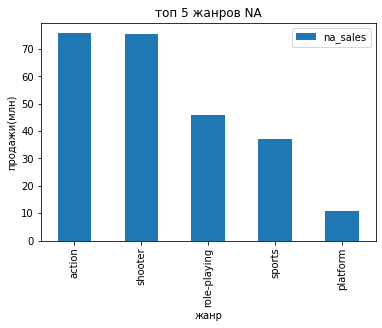

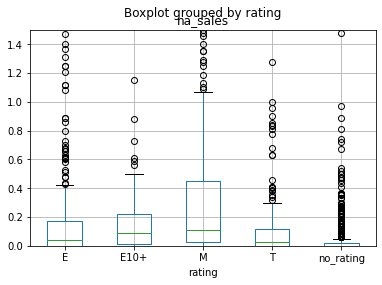

In [27]:
 df_1.groupby(by='platform').agg({'na_sales': 'sum'}
                                ).sort_values(by='na_sales', ascending=False
                                              ).head().plot(kind='bar', title='топ 5 платформ NA')
                                           
plt.xlabel('платформа')
plt.ylabel('продажи(млн)')
plt.show()

df_1.groupby(by='genre').agg({'na_sales': 'sum'}
                                ).sort_values(by='na_sales', ascending=False
                                              ).head().plot(kind='bar', title='топ 5 жанров NA')
                                             
plt.xlabel('жанр')
plt.ylabel('продажи(млн)')
plt.show()
    

df_1.boxplot(column='na_sales', by='rating')
plt.ylim(0,1.5)
plt.show()

## EU

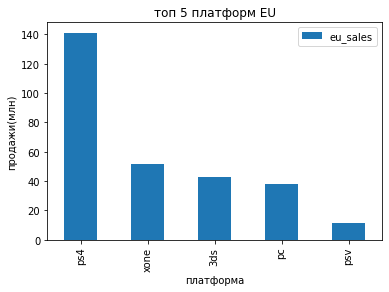

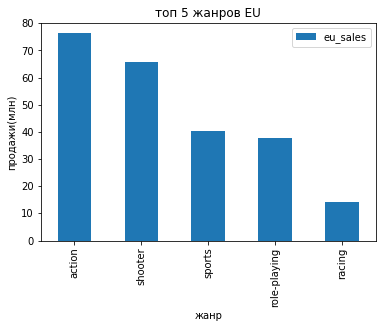

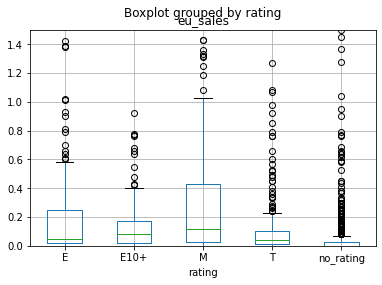

In [28]:
df_1.groupby(by='platform').agg({'eu_sales': 'sum'}
                                ).sort_values(by='eu_sales', ascending=False
                                              ).head().plot(kind='bar', title='топ 5 платформ EU')
plt.xlabel('платформа')
plt.ylabel('продажи(млн)')
plt.show()

df_1.groupby(by='genre').agg({'eu_sales': 'sum'}
                                ).sort_values(by='eu_sales', ascending=False
                                              ).head().plot(kind='bar', title='топ 5 жанров EU')
plt.xlabel('жанр')
plt.ylabel('продажи(млн)')
plt.show()       

df_1.boxplot(column='eu_sales', by='rating')
plt.ylim(0,1.5)
plt.show()

## JP

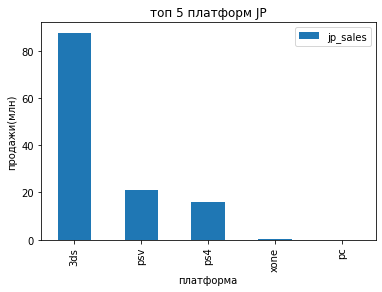

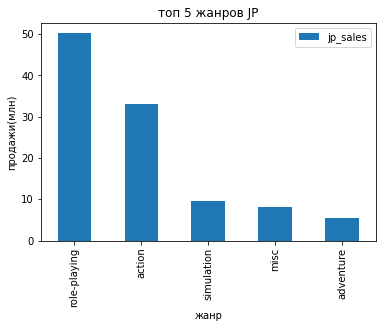

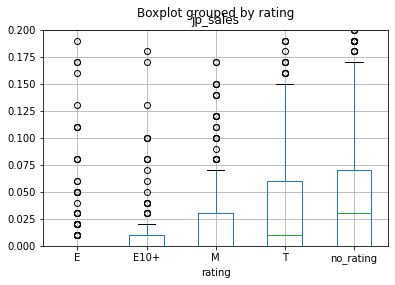

In [29]:
df_1.groupby(by='platform').agg({'jp_sales': 'sum'}
                                ).sort_values(by='jp_sales', ascending=False
                                              ).head().plot(kind='bar', title='топ 5 платформ JP')
plt.xlabel('платформа')
plt.ylabel('продажи(млн)')
plt.show()

df_1.groupby(by='genre').agg({'jp_sales': 'sum'}
                                ).sort_values(by='jp_sales', ascending=False
                                              ).head().plot(kind='bar', title='топ 5 жанров JP')
plt.xlabel('жанр')
plt.ylabel('продажи(млн)')
plt.show()  

df_1.boxplot(column='jp_sales', by='rating')
plt.ylim(0,0.2)
plt.show()

- из данного анализа мы видим что рейтинг влияет на количество продаж.
- в регионах NA и EU предпочитают жанры action и shooter имеющие возростной рейтирнг "для взрослых"
- в регионе JP предпочитают ролевые игры

# Гипотезы

In [30]:
# создаем новый датафрейм для удаления пропусков перед проверкой гипотез
df_2 = df_1

In [31]:
# удаляем пропуски
df_2.dropna(subset=['user_score'], inplace=True)

## оценки пользователей PC и Xone равны

- H0: оценки пользователей PC и Xone равны
- H1: оценки пользователей PC и Xone не равны

In [32]:
alpha =0.05
results = st.ttest_ind(
    df_2.query('platform == "pc"')['user_score'], df_2.query(
        'platform == "xone"')['user_score'], equal_var = False) 

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


## оценки в жанрах равны

- H0: оценки пользователей в жанрах action и sports равны
- H1: оценки пользователей в жанрах action и sports не равны

In [33]:
alpha =0.05
results = st.ttest_ind(
    df_2.query('genre == "action"')['user_score'], df_2.query(
        'genre == "sports"')['user_score'], equal_var = False) 

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  9.369107753838216e-11
Отвергаем нулевую гипотезу


# вывод

**из проведенного исследования видно:**

    - предпочтаемы платформы и жанры отличаются по регионам
    - оценки критиков и пользователей не имеют большого влияния на продажи
    - рынки NA и EU похожи
    - среднее время жизни платформы составляет 8 лет
    - уверенным лидером по количеству проданных копий являлась платформа ps2, более 1200 млн проданных копий
    - в 2012 году начался резкий спад продаж
    - после 2012 года мединное количество продаж примерно равно у 3ds, PS4, Xone
    - предпочитаемы жанры по регионам различаются, что подтверждается количеством продаж в зависимости от рейтинга

**при составлении прогноза продаж руководствовался бы следующими правилами:**

    
**для региона NA:**

    - PS4- 35%
    - XOne- 30%
    - 3DS- 15%
    - PC- 10%
    - PSV- 5%
    - еще 5% оставил бы на другие платформы ориентируясь по ситуации

    распределение по жанрам:

        - action- 25%
        - shooter - 25%
        - sports- 20%
        - role_playing- 15%
        - platform- 5%
        - 10% для остальных жанров
<br>
<br>
<br>

**для региона UA:**

    - PS4- 40%
    - XOne- 20%
    - PC- 20%
    - 3DS- 10%
    - PSV- 5%
    - еще 5% оставил бы на другие платформы ориентируясь по ситуации

    **распределение по жанрам:**

        - action- 30%
        - shooter - 25%
        - sports- 20%
        - role_playing- 15%
        - racing- 5%
        - 5% для остальных жанров
<br>
<br>
<br>


**для региона JP:**

    - 3DS- 60%
    - PS4- 25%
    - PSV- 20%
    - XOne- 5%
    - PC- не популярна

    **распределение по жанрам:**

        - role_playing- 35%
        - action- 30%
        - simulation- 15% 
        - platform- 10
        - shooter- 5
        - 5% на остальные жанры по ситуации